In [1]:
%pip install corels
%pip install numpy==1.23.1

In [2]:
import numpy as np
import pylab as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from corels import CorelsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

from itertools import combinations

# Given: A function to generate a random toy dataset
- Here is a function that generates a toy dataset with binary features, binary labels, and a train and test split.
- Use this function to generate random datasets for the remainder of this checkpoint notebook.

In [3]:
def generate_data():
    N = 1000
    D = 4

    X = np.random.choice( [ 0 , 1 ] , size=( N , D ) , replace=True )

    y = np.zeros( N )
    for i in range( 1 , D+1 ):
        for nz_indices in combinations( np.arange( D ) , i ):
            feats = np.zeros( D )
            feats[ list( nz_indices ) ] = 1.
            label = np.random.binomial( 1 , p=0.25 )
            if label == 1: ##Update label for instances with those features
                instances_with_feats = []
                for j , vec in enumerate( X ):
                    if np.array_equal( vec , feats ):
                        assert y[ j ] == 0
                        y[ j ] = label


    feature_names = [ "Feat " + str( i ) for i in range( D ) ]

    ##Train/test split
    train_indices , test_indices = train_test_split( np.arange( X.shape[ 0 ] ) , test_size=int( X.shape[ 0 ] / 4 ) )
    train_indices , valid_indices = train_test_split( train_indices , test_size=int( len( train_indices ) / 4 ) )

    return X , y , train_indices , test_indices , feature_names

X , y , train_indices , test_indices , feature_names = generate_data()

# Train and visualize a decision tree classifier

- Train a decision tree classifier using scikit-learn's implementation with default parameter values.  
- Print the accuracy score on both the train and test sets.
- Use the plot_tree function in scikit-learn to show a visualization of the tree.  See the documentation here for design choices:n https://scikit-learn.org/1.5/modules/generated/sklearn.tree.plot_tree.html  At the minimum, your leaf nodes should have a label corresponding to the prediction made at that leaf node.

Train Accuracy: 1.0
Test Accuracy: 1.0


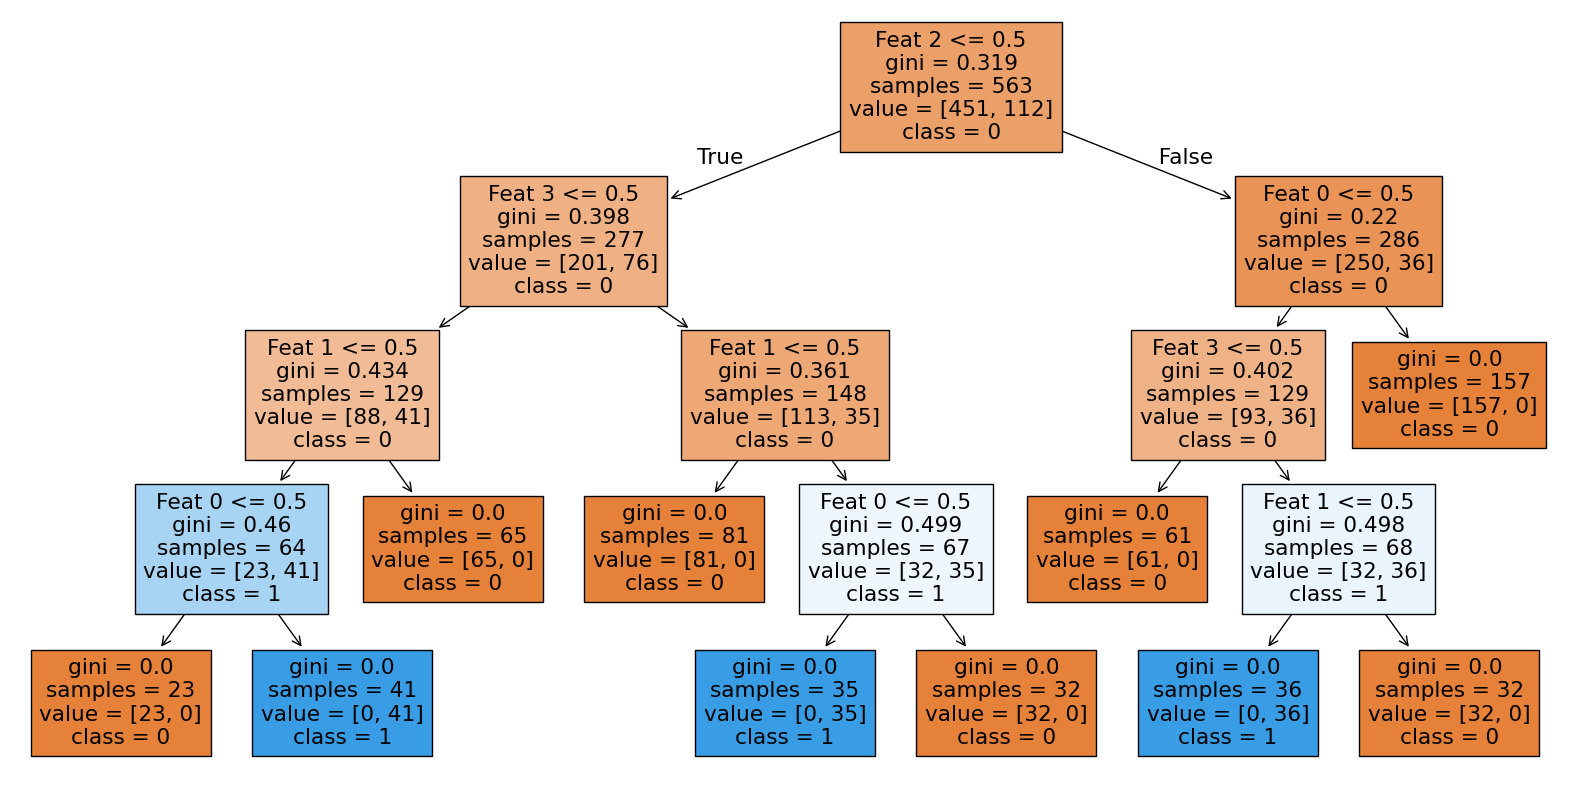

In [4]:
dtc = DecisionTreeClassifier()
dtc.fit(X[train_indices], y[train_indices])
y_pred_train = dtc.predict(X[train_indices])
y_pred_test = dtc.predict(X[test_indices])

print("Train Accuracy:", accuracy_score(y[train_indices], y_pred_train))
print("Test Accuracy:", accuracy_score(y[test_indices], y_pred_test))

plt.figure(figsize=(20, 10))
tree.plot_tree(dtc, feature_names=feature_names, class_names=["0", "1"], filled=True)
plt.show()

# Compute some interpretability proxies for decision trees

- Write a function that takes in a DecisionTreeClassifier object and a feature matrix and returns the values of the 3 interpretability proxies.
1. The number of leaf nodes in the tree
2. The number of non-leaf nodes in the tree
3. The average path length to (number of non-leaf nodes traversed) to make a prediction.  Compute this on the feature matrix passed into the function

Proxies 1 and 3 can be fairly straightforwardly computed using methods from the DecisionTreeClassifier.  See the documentation here: https://scikit-learn.org/dev/modules/generated/sklearn.tree.DecisionTreeClassifier.html

Proxy 2 can be done by accessing the tree's node count.  If your decision tree classifier is named clf, you can access the node count like this: clf.tree_.node_count

- Use your function to compute and print these statistics on the test set for your trained decision tree.

In [19]:
def compute_interpretability_proxies(dtc, X):
    num_leaf_nodes = dtc.tree_.n_leaves
    num_non_leaf_nodes = dtc.tree_.node_count - dtc.tree_.n_leaves
    avg_path_length = np.mean(np.sum(X, axis=1))

    return num_leaf_nodes, num_non_leaf_nodes, avg_path_length

compute_interpretability_proxies(dtc, X)

(7, 6, 2.019)

# Train and visualize a Rule List

- Train a rule list using the CORELS implementation with the following parameter values: n_iter=10000 , verbosity=[], max_card=3 , c=0.01
- Print the accuracy score on both the train and test sets.
- Print a visualization of the rule list.  You can do this by printing the model itself.


In [6]:
cc = CorelsClassifier(n_iter=10000, verbosity=[], max_card=3, c=0.01)
cc.fit(X[train_indices], y[train_indices])

y_pred_train = cc.predict(X[train_indices])
y_pred_test = cc.predict(X[test_indices])

print("Train Accuracy:", accuracy_score(y[train_indices], y_pred_train))
print("Test Accuracy:", accuracy_score(y[test_indices], y_pred_test))

print('\n', cc)

Train Accuracy: 0.9591474245115453
Test Accuracy: 0.94

 CorelsClassifier ({'c': 0.01, 'n_iter': 10000, 'map_type': 'prefix', 'policy': 'lower_bound', 'verbosity': [], 'ablation': 0, 'max_card': 3, 'min_support': 0.01})
RULELIST:
if [feature2 && feature3 && feature4]:
  prediction = False
else if [feature2 && feature4 && not feature1]:
  prediction = True
else if [feature3 && feature4 && not feature1]:
  prediction = True
else if [not feature2 && not feature3 && not feature4]:
  prediction = True
else 
  prediction = False


# Compute some interpretability proxies for rule lists

This is a similar idea to computing the 3 interpretability proxies for the decision tree classifier, but it will take more work since these functions aren't built into CORELS.  

Several of these functions will require accessing the underlying representation of the CORELS rules.  You can do this (if your model is named corels) like this: corels.rl().rules  Understanding this representation is easiest when comparing it directly to the printed visualization of the same model.

We will break this into 2 steps:
1. Writing a custom predict function to compute the decision path
2. Writing a function to compute interpretability proxies for a rule list

## A custom predict function to compute the decision path

You should implement your own predict function that takes in a list of feature values for an instance (one row of your feature matrix) and a trained CORELS model.  Your function should return the prediction, and the number of feature evaluations (what we called conditions in class.  i.e. is feature 1 == 1?) needed to make the prediction.

When counting the number of feature evaluations, you should assume that you can stop evaluating features within a rule as soon as one part of the rule is False (since this model uses ands, this is enough to know the rule does not apply).

You may find it helpful to write a function to check if a single rule applies, and counts how many features were evaluated to determine this.  Whether you implement this as a separate function or not is up to you.

Test your custom predict function in the following 2 ways:
 1. Verify that your function's predictions match the predictions made by the corels model
 2. Verify on 3-4 instances that the number of feature evaluations matches a manual count of the number of feature evaluations (similar to what you did in class).


In [7]:
def custom_predict(corels_model, feature_values):

  fcount = 0

  for rule in corels_model.rl().rules:

    applies = True
    rule_evaluations = 0

    for antecedent in rule['antecedents']:

      rule_evaluations += 1

      feature_index = abs(antecedent) - 1

      feature_value = antecedent > 0

      if feature_values[feature_index] != feature_value:
        applies = False
        break

    if applies:
      fcount += rule_evaluations
      return rule['prediction'], fcount

  return False, fcount

In [8]:
random_indices = np.random.choice(len(X[test_indices]), size=5, replace=False)

for i in random_indices:

  print(f"Random instance {i}: ", X[i])
  print("Corels prediction:", cc.predict(X[test_indices])[i:(i+1)][0])

  custom_prediction, count = custom_predict(cc, X[test_indices][i])
  print(f"Custom prediction and count: {custom_prediction}, {count}")

  if cc.predict(X[test_indices])[i:(i+1)] == custom_prediction:
    print("Predictions match! \n")
  else:
    print("Predictions don't match! \n")

Random instance 67:  [0 0 1 0]
Corels prediction: True
Custom prediction and count: True, 3
Predictions match! 

Random instance 36:  [1 0 0 0]
Corels prediction: False
Custom prediction and count: False, 3
Predictions match! 

Random instance 228:  [1 1 0 1]
Corels prediction: True
Custom prediction and count: True, 3
Predictions match! 

Random instance 219:  [1 1 1 0]
Corels prediction: True
Custom prediction and count: True, 3
Predictions match! 

Random instance 126:  [0 0 0 0]
Corels prediction: False
Custom prediction and count: False, 0
Predictions match! 



## Compute some interpretability proxies for rule lists

- Write a function that takes in a CorelsClassifier object and a feature matrix and returns the values of the 3 interpretability proxies.
1. The number of rules in the rule list
2. The number of feature evaluations in the rule list (what we called conditions in class. i.e. is feature 1 == 1?)
3. The average number of feature evaluations needed to make a prediction.  Compute this on the feature matrix passed into the function

Proxy 3 can be computed using your custom predict function.  Proxy 1 can be computed straightforwardly from the underlying rule list representation.  Proxy 2 requires iterating through the rules in the rule list and you may choose to implement this as a separate function.

- Use your function to compute and print these statistics on the test set for your trained rule list

In [9]:
def custom_interpretability_proxies(corels_model, feature_matrix):


  num_rules = len(corels_model.rl().rules) # proxy 1

  total_conditions = 0

  for rule in corels_model.rl().rules:
    num_conditions = len(rule['antecedents'])
    total_conditions += num_conditions # proxy 2

  total_evals = 0

  for instance in feature_matrix:
    _, eval_count = custom_predict(corels_model, instance)
    total_evals += eval_count

  avg_evals = total_evals / len(feature_matrix) # proxy 3

  return num_rules, total_conditions, avg_evals

In [10]:
num_rules, total_conditions, avg_evals = custom_interpretability_proxies(cc, X[test_indices])

print("Number of rules:", num_rules)
print("Total conditions:", total_conditions)
print("Average evaluations:", avg_evals)

Number of rules: 5
Total conditions: 13
Average evaluations: 1.528


# Compute and graph these interpretability proxies for many randomly generated datasets

- Graph the mean and the standard error of the 3 interpretability proxies for 100 randomly generated toy datasets sampled using the provided generate_data function on both your decision tree and your rule list.

You should use the same parameter values that were specified previously for both models.

The interpretability proxies are listed in the same order for both models.  E.g. graph both metrics for proxy 1 on the same graph.  

Your graphs should include titles and axis labels.  

Note that standard error is not what comes out of numpy's std function, but it is a simple transformation of that output.  You can take a look at the wikipedia page: https://en.wikipedia.org/wiki/Standard_error The standard error is useful because it shrinks as you increase the number of randomly sampled datasets.  (You can test this experimentally by plotting your values with 10 randomly generated datasets, then 500 or 1000 and comparing the figures.)

Your figure will look something like the one below, but your error bars should be much smaller since I generated this with only 10 random datasets.

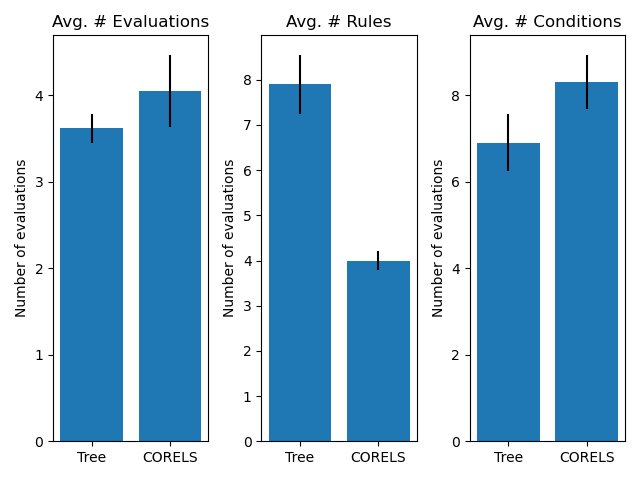

In [11]:
def standard_error(data):

  return np.std(data) / np.sqrt(len(data))

In [12]:
def compute_proxies_for_datasets(corels_model, dtc_model, num_datasets = 100):

  corels_proxies = [[] for i in range(3)]
  dtc_proxies = [[] for i in range(3)]

  for i in range(num_datasets):

    X, y, train_indices, test_indices, feature_names = generate_data()

    # corels proxies
    corels_model.fit(X[train_indices], y[train_indices])
    num_rules, total_conditions, avg_evals = custom_interpretability_proxies(corels_model, X[test_indices])

    corels_proxies[0].append(num_rules)
    corels_proxies[1].append(total_conditions)
    corels_proxies[2].append(avg_evals)

    # decision tree proxies
    dtc_model.fit(X[train_indices], y[train_indices])
    num_rules, total_conditions, avg_evals = compute_interpretability_proxies(dtc_model, X[test_indices])

    dtc_proxies[0].append(num_rules)
    dtc_proxies[1].append(total_conditions)
    dtc_proxies[2].append(avg_evals)

  return corels_proxies, dtc_proxies

In [13]:
def plot_proxies(corels_proxies, dtc_proxies):

  means_corels = [np.mean(proxy) for proxy in corels_proxies]
  means_dtc = [np.mean(proxy) for proxy in dtc_proxies]

  # standard error
  se_corels = [standard_error(proxy) for proxy in corels_proxies]
  se_dtc = [standard_error(proxy) for proxy in dtc_proxies]

  proxy_names = ["Avg. # Evaluations", "Avg. # Rules", "Avg. # Conditions"]

  fig, axs = plt.subplots(1, 3, figsize=(6, 6), sharey=True)

  for i, (label, mean_corels, mean_dtc, error_corels, error_dtc) in enumerate(zip(proxy_names, means_corels, means_dtc, se_corels, se_dtc)):

    axs[i].bar(['Tree'], [mean_dtc], yerr = [error_dtc], capsize = 5 , label = "Tree") # capsize is for adding a horizonal line for error line
    axs[i].bar(['Corels'], [mean_corels], yerr = [error_corels], capsize = 5, label = "Corels")
    axs[i].set_title(label)

    if i == 0:
      axs[i].set_ylabel("Number of Evaluations")

    # axs[i].legend()

  plt.tight_layout()
  plt.show()

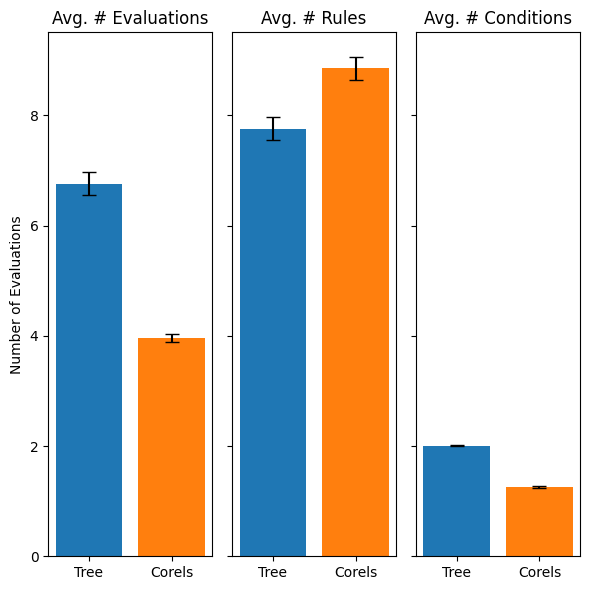

In [14]:
corels_proxies, dtc_proxies = compute_proxies_for_datasets(cc, dtc)
plot_proxies(corels_proxies, dtc_proxies)

# Sample a typical dataset for your user study

- Sample toy datasets using the provided generate_data function until you find a dataset that:
1. Is close enough to the means computed above for all 3 interpretability proxies for both models (6 metrics total)
2. Has at least 4 distinct (i.e. at least some feature values are different) positive and negative test instances that are close enough to interpretability proxy 3 on both models.  (8 instances total).

"Close enough" should be operationalized in both cases as within 1 of the mean value of the interpretability proxy.  
- E.g. if the decision tree's mean path length is 3.7 across the 100 datasets in your previous experiment, then you should find models where the mean path length is between 2.7 and 4.7

- E.g. if your chosen dataset's decision tree has a mean path length of 3.2, you should have at least 4 distinct positive and negative test instances that have decision path lengths of 3 or 4.

Note that by "positive instances" I mean instances where the label and predictions from both model are all 1.  For "negative instances," these should all be 0.

As above, You should use the same parameter values that were specified previously for both models.

You may need to sample many datasets to achieve this.  Use a while loop!

- Print the 2 models, and the 8 instances, each with their corresponding label.  You should also print the 3 interpretability proxies for both models.

In [15]:
def threshold_check(target, value, threshold=1):
  if value > target - threshold and value < target + threshold:
    return True
  else:
    return False

# means_corels = [np.mean(proxy) for proxy in corels_proxies]
# means_dtc = [np.mean(proxy) for proxy in dtc_proxies]

# sample_corels_proxies = [[] for i in range(3)]
# sample_dtc_proxies = [[] for i in range(3)]

# while True:
#   X, y, train_indices, test_indices, feature_names = generate_data()

#   cc.fit(X[train_indices], y[train_indices])
#   num_rules, total_conditions, avg_evals = custom_interpretability_proxies(cc, X[test_indices])

#   sample_corels_proxies[0] = [num_rules]
#   sample_corels_proxies[1] = [total_conditions]
#   sample_corels_proxies[2] = [avg_evals]

#   dtc.fit(X[train_indices], y[train_indices])
#   num_rules, total_conditions, avg_evals = compute_interpretability_proxies(dtc, X[test_indices])

#   sample_dtc_proxies[0] = [num_rules]
#   sample_dtc_proxies[1] = [total_conditions]
#   sample_dtc_proxies[2] = [avg_evals]

#   if threshold_check(means_corels[0], sample_corels_proxies[0]) and threshold_check(means_corels[1], sample_corels_proxies[1]) and threshold_check(means_corels[2], sample_corels_proxies[2]):
#     break

# plot_proxies(sample_corels_proxies, sample_dtc_proxies)

In [24]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from itertools import combinations

assifier(n_iter=10000, verbosity=[], max_card=3, c=0.01)
dtc_model = DecisionTreeClassifier()

means_corels = [np.mean(proxy) for proxy in corels_proxies]
means_dtc = [np.mean(proxy) for proxy in dtc_proxies]

while True:
    X, y, train_indices, test_indices, feature_names = generate_data()

    corels_model.fit(X[train_indices], y[train_indices])
    dtc_model.fit(X[train_indices], y[train_indices])

    corels_proxies = custom_interpretability_proxies(corels_model, X[test_indices])
    dtc_proxies = compute_interpretability_proxies(dtc_model, X[test_indices])

    proxies_within_threshold = all(
        threshold_check(mean_val, proxy, threshold=1)
        for mean_val, proxy in zip(means_corels + means_dtc, corels_proxies + dtc_proxies)
    )

    if not proxies_within_threshold:
        continue

    positive_instances = set()
    negative_instances = set()

    positive_instances = []
    negative_instances = []

    for idx in test_indices:
        feature_values = X[idx]
        label = y[idx]

        corels_pred, corels_eval_count = custom_predict(corels_model, feature_values)
        dtc_pred = dtc_model.predict([feature_values])[0]
        dtc_eval_count = sum(dtc_model.decision_path([feature_values]).toarray()[0])

        if corels_pred == dtc_pred == label:
            if label == 1 and len(positive_instances) < 4:
                if (feature_values.tolist(), label) not in [(inst[0].tolist(), inst[1]) for inst in positive_instances]:
                    if threshold_check(corels_proxies[2], corels_eval_count) and threshold_check(dtc_proxies[2], dtc_eval_count):
                        positive_instances.append((feature_values, label))
            elif label == 0 and len(negative_instances) < 4:
                if (feature_values.tolist(), label) not in [(inst[0].tolist(), inst[1]) for inst in negative_instances]:
                    if threshold_check(corels_proxies[2], corels_eval_count) and threshold_check(dtc_proxies[2], dtc_eval_count):
                        negative_instances.append((feature_values, label))

        if len(positive_instances) >= 4 and len(negative_instances) >= 4:
            break


    if len(positive_instances) >= 4 and len(negative_instances) >= 4:
        print("Decision Tree Model:\n", dtc_model)
        print("\nCORELS Model:\n", corels_model)

        print("\nInterpretability Proxies for Decision Tree:", dtc_proxies)
        print("Interpretability Proxies for CORELS:", corels_proxies)

        print("\nPositive Instances (feature values, label):")
        for instance in positive_instances:
            print(instance)

        print("\nNegative Instances (feature values, label):")
        for instance in negative_instances:
            print(instance)

        break

Decision Tree Model:
 DecisionTreeClassifier()

CORELS Model:
 CorelsClassifier ({'c': 0.01, 'n_iter': 10000, 'map_type': 'prefix', 'policy': 'lower_bound', 'verbosity': [], 'ablation': 0, 'max_card': 3, 'min_support': 0.01})
RULELIST:
if [feature1 && feature4]:
  prediction = True
else if [feature3 && feature4 && not feature2]:
  prediction = True
else if [feature2 && not feature1 && not feature3]:
  prediction = True
else 
  prediction = False

Interpretability Proxies for Decision Tree: (9, 8, 2.084)
Interpretability Proxies for CORELS: (4, 9, 1.52)

Positive Instances (feature values, label):
(array([1, 1, 1, 1]), 1.0)
(array([1, 0, 1, 1]), 1.0)
(array([1, 1, 0, 1]), 1.0)
(array([1, 0, 0, 1]), 1.0)

Negative Instances (feature values, label):
(array([0, 0, 1, 0]), 0.0)
(array([1, 1, 1, 0]), 0.0)
(array([1, 0, 1, 0]), 0.0)
(array([0, 1, 1, 0]), 0.0)


CorelsClassifier ({'c': 0.01, 'n_iter': 10000, 'map_type': 'prefix', 'policy': 'lower_bound', 'verbosity': [], 'ablation': 0, 'max_card': 3, 'min_support': 0.01})
RULELIST:
if [feature1 && feature4]:
  prediction = True
else if [feature3 && feature4 && not feature2]:
  prediction = True
else if [feature2 && not feature1 && not feature3]:
  prediction = True
else 
  prediction = False


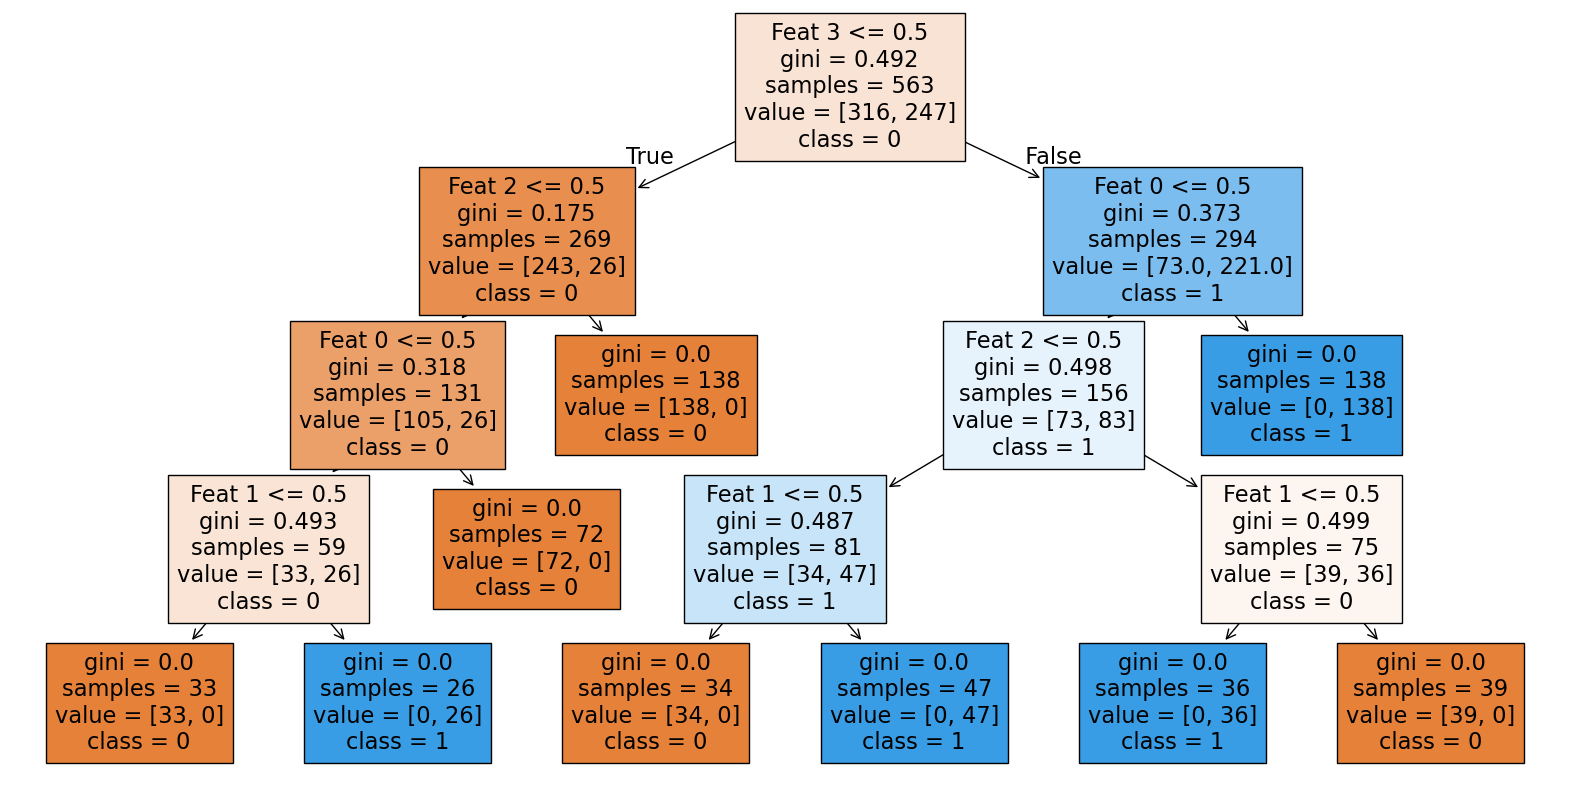

In [25]:
print(corels_model)

plt.figure(figsize=(20, 10))
tree.plot_tree(dtc_model, feature_names=feature_names, class_names=["0", "1"], filled=True)
plt.show()

## Implement a barebones Qualtrics survey comparing the 2 models above using a simulation task

Here are the requirements for your survey:
- Your survey should include 2 blocks of 4 trials.  Each block should correspond to 1 model.
- Each trial (there are 8 total) should correspond to a different instance from the 8 you sampled above.
- Each block should have 2 trials with positive instances and 2 trials with negative instances
- The order of the blocks should be randomized.
- The order of the trials within each block should be randomized.
- Each trial should be timed.

Each individual trial should ask the user to simulate the prediction of the provided instance given the provided model.  For the simplest version of this, you can take screenshots of each model and each instance.

#### Paste the link to your trial here: https://colby.co1.qualtrics.com/jfe/form/SV_cXSvx3ND0SDBZae

#### Include a screenshot of 1 trial from each block (1 for each model) here:

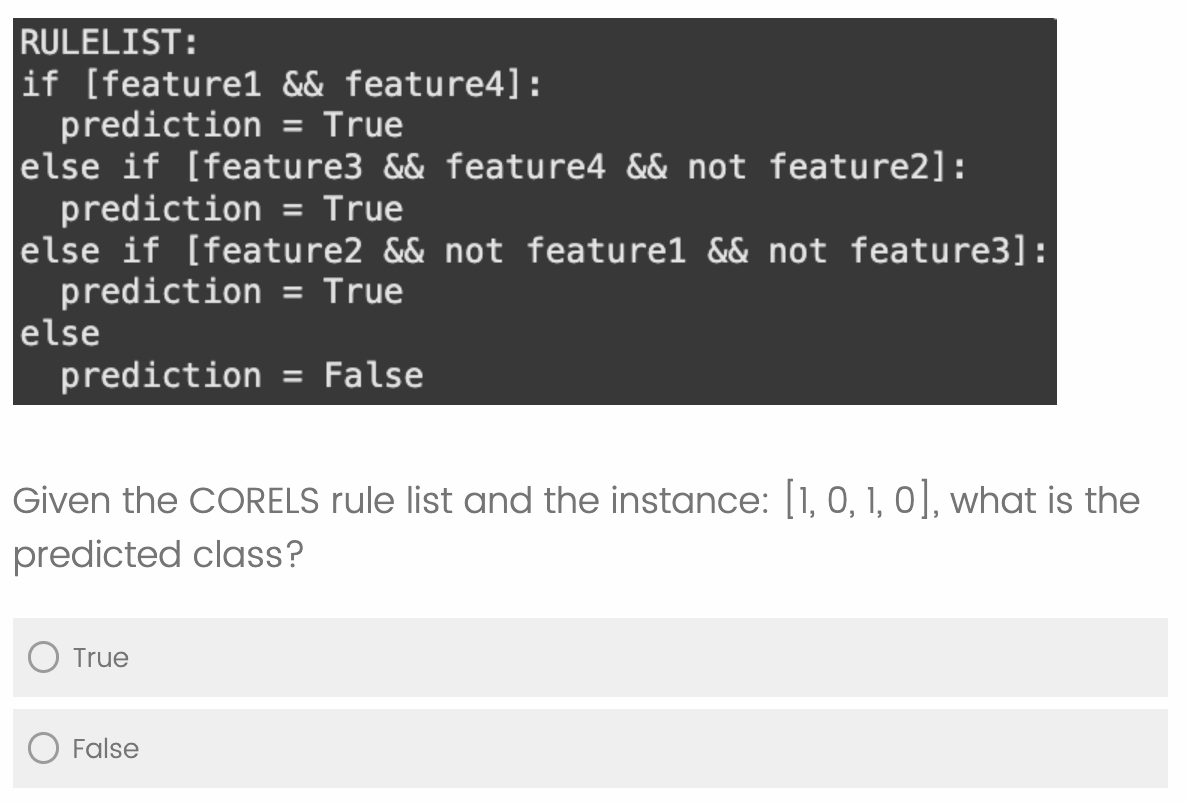

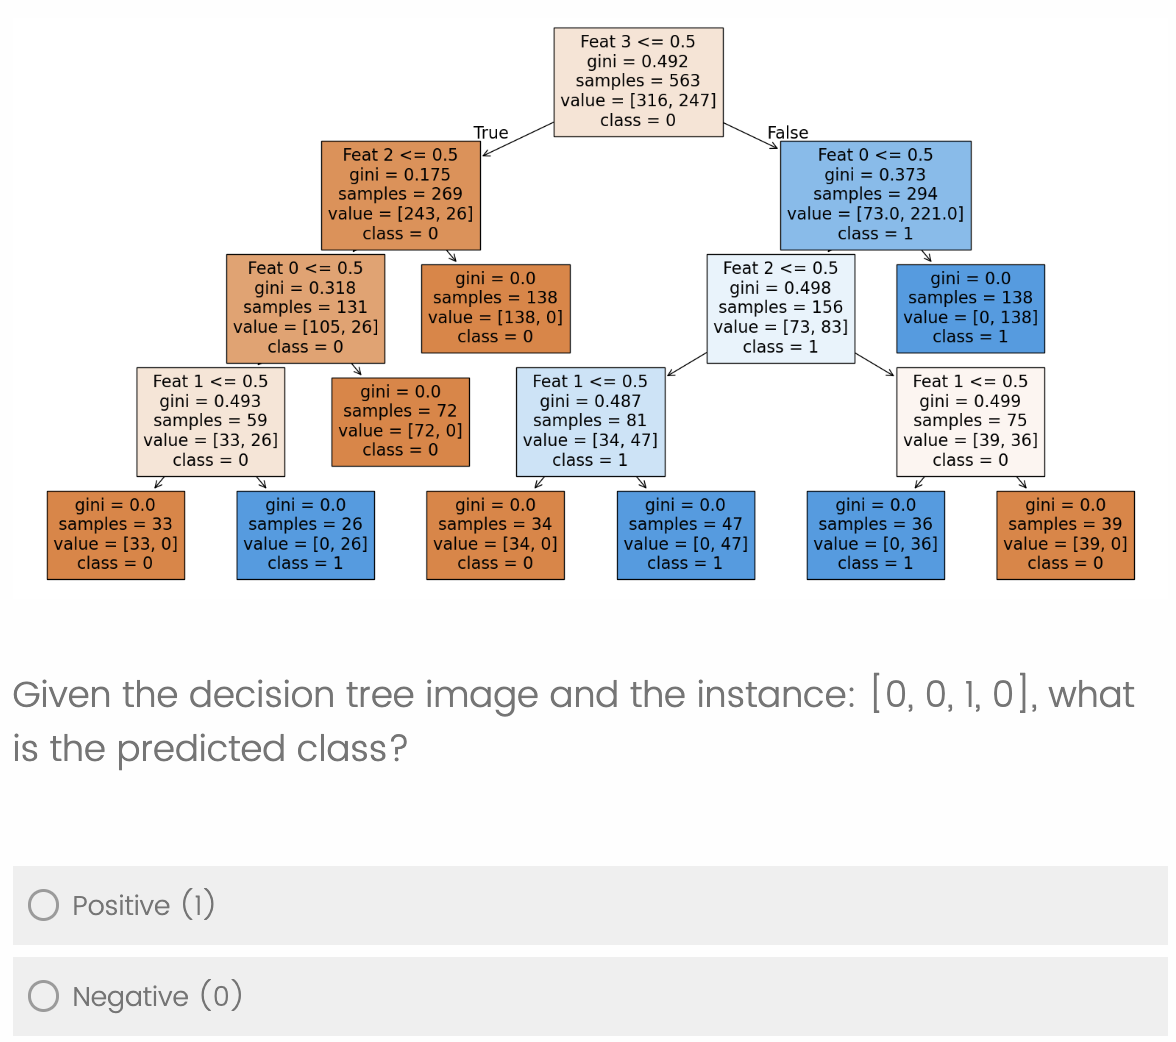